# Visualisations for the effect of control interval

In [1]:
from typing import List
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
from matplotlib.ticker import MaxNLocator
from cmcrameri import cm

Standard plotting parameters

In [2]:
### Latex font in plots
plt.rcParams['font.serif'] = "cmr10"
plt.rcParams['font.family'] = "serif"
plt.rcParams['font.size'] = 24

plt.rcParams['legend.fontsize'] = 24
plt.rcParams['legend.loc'] = 'upper right'
plt.rcParams['axes.labelsize'] = 24
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['text.usetex'] = False
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams["axes.grid"] = False
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['axes.linewidth'] = 2   # Default for all spines
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
# plt.rcParams['text.usetex'] = True
plt.rcParams['xtick.major.size'] = 6  # Thicker major x-ticks
plt.rcParams['xtick.major.width'] = 2  # Thicker major x-
plt.rcParams['ytick.major.size'] = 6  
plt.rcParams['ytick.major.width'] = 2 
plt.rc('axes', unicode_minus=False)


### Helper function to load in data as pandas DataFrame

In [3]:
def load_data_file(step_size: str, n_days: int = 10, control_frequency: int = 1) -> pd.DataFrame:
    '''
    Load a single data file with the results of the simulation
    Arguments:
        step_size: str, step size of the simulation
        n_days: int, number of days of the simulation
        control_frequency: int, control frequency of the simulation
    returns:
        python_variables: pd.DataFrame, data from the simulation
    '''
    python_variables = pd.read_csv(f"../data/model-comparison/python-rule-based/step-size-{step_size}-control-frequency-{control_frequency}-{n_days}.csv", sep=",")[:]
    return python_variables

def load_all_data(step_sizes: List[str], control_frequencies: List[int], n_days: int = 10) -> List[List[pd.DataFrame]]:
    '''
    Load all data from the experiments checking step size and control frequency.
    Arguments:
        step_sizes: List[str], step sizes of the simulation
    returns:
        python_variables: List[pd.DataFrame], data from the simulation
    '''
    experiment_step_size_res = []

    for step in step_sizes:
        python_states = []
        for control_freq in control_frequencies[:]:
            py_states = load_data_file(step, n_days=n_days, control_frequency=control_freq)
            python_states.append(py_states)
        experiment_step_size_res.append(python_states)
    return experiment_step_size_res



In [4]:
matlab_timing = [115.3312, 113.6639, 117.1956, 113.6042, 116.7673, 114.0659, 113.2125, 114.9254, 114.6993, 114.5638]
matlab_timing_mean = np.mean(matlab_timing)
matlab_timing_std = np.std(matlab_timing)

In [5]:
control_frequencies = [2, 4, 8, 16] + [i*30 for i in range(1, 121)]
n_days = 10
step_sizes = ['0.5', '1.0', '2.0']

experiment_step_size_res = load_all_data(step_sizes, control_frequencies, n_days)

In [6]:
step_size_run_time_data = [pd.concat(python_states) for python_states in experiment_step_size_res]
step_size_run_time_data_unique = [df.drop_duplicates(subset=['Control frequency', 'episode']).loc[:,['Run time', 'Control frequency', 'episode']] for df in step_size_run_time_data]

step_size_run_time_mean = [df.groupby('Control frequency', as_index=False).mean() for df in step_size_run_time_data_unique]
step_size_run_time_std = [df.groupby('Control frequency', as_index=False).std() for df in step_size_run_time_data_unique]

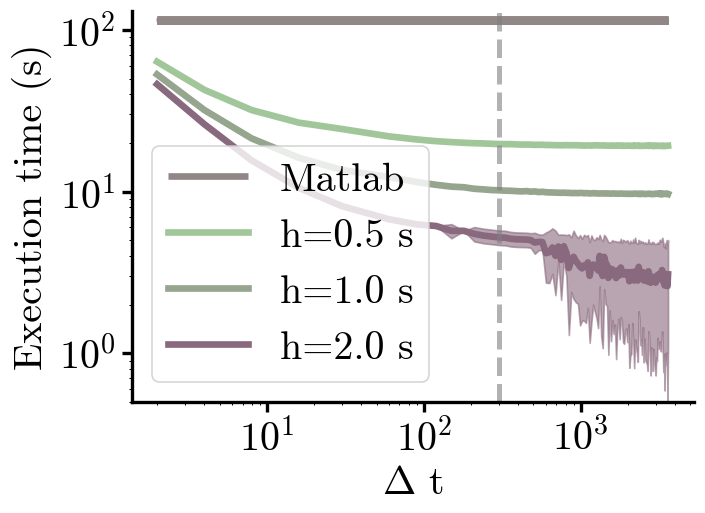

In [7]:
fig = plt.figure(dpi=120)
ax = fig.add_subplot()

colors = [cm.tokyoS(i) for i in range(4,7)]

ax.hlines(matlab_timing, xmin=2, xmax=3600, label="Matlab", linewidth=4, linestyle="-", colors=cm.tokyoS(2), alpha=1.0)
ax.fill_between([2, 3600], matlab_timing_mean - matlab_timing_std, matlab_timing_mean + matlab_timing_std, color=cm.tokyoS(2), alpha=0.6)

for i, df_mean in enumerate(step_size_run_time_mean):
    ax.plot(df_mean['Control frequency'], df_mean['Run time'], linewidth=4, color=colors[i], label=f'h={step_sizes[i]} s')
    ax.fill_between(df_mean['Control frequency'], df_mean['Run time'] - step_size_run_time_std[i]['Run time'], df_mean['Run time'] + step_size_run_time_std[i]['Run time'], color=colors[i], alpha=0.6)

ylim = ax.get_ylim()
ax.vlines(300, 0.5, 200, linestyle="--", linewidth=3, color='grey', alpha=0.6)

ax.set_ylim(0.5, 130)

ax.set_ylabel("Execution time (s)")
ax.set_xlabel(r"$\Delta$ t")
ax.set_yscale('log')
ax.set_xscale('log')
ax.legend(loc='lower left')
fig.tight_layout()
fig.savefig("execution_time.svg")
plt.show()


In [8]:
def compute_relative_diff(truth, deviation):
    return (deviation-truth)/truth * 100

In [9]:
df = step_size_run_time_data[1]

# def relative_change_profit(df, )

profit_grouped = df.groupby(['Control frequency', 'episode'])['Profits'].sum().reset_index()

# Filtdf_corrected.set_index('episode', inplace=True)er the DataFrame for control frequency 2.0 for easy reference
# profit_grouped.set_index('episode', inplace=True)

cf_2_corrected = profit_grouped[profit_grouped['Control frequency'] == 2.0]['Profits']

profit_grouped['Relative Change in Profit'] = profit_grouped.apply(
    lambda row: ((row['Profits'] - cf_2_corrected.loc[row['episode']]) / cf_2_corrected.loc[row['episode']]  *100) 
                if row['Control frequency'] != 2.0 else 0, axis=1)


In [20]:
# take the mean of the relative change in profit for each control frequency
relative_change_mean = profit_grouped.groupby('Control frequency')['Relative Change in Profit'].mean()
relative_change_std = profit_grouped.groupby('Control frequency')['Relative Change in Profit'].std()
# relative_change
relative_change_mean, relative_change_std

(Control frequency
 2.0       0.000000
 4.0      -0.000662
 8.0      -0.002225
 16.0     -0.000901
 30.0     -0.003678
             ...   
 3480.0   -5.460448
 3510.0   -5.754128
 3540.0   -5.930087
 3570.0   -6.529432
 3600.0   -6.620819
 Name: Relative Change in Profit, Length: 124, dtype: float64,
 Control frequency
 2.0       0.000000
 4.0       0.003799
 8.0       0.007594
 16.0      0.006166
 30.0      0.011734
             ...   
 3480.0    7.297563
 3510.0    6.380958
 3540.0    6.744134
 3570.0    6.593048
 3600.0    7.397788
 Name: Relative Change in Profit, Length: 124, dtype: float64)

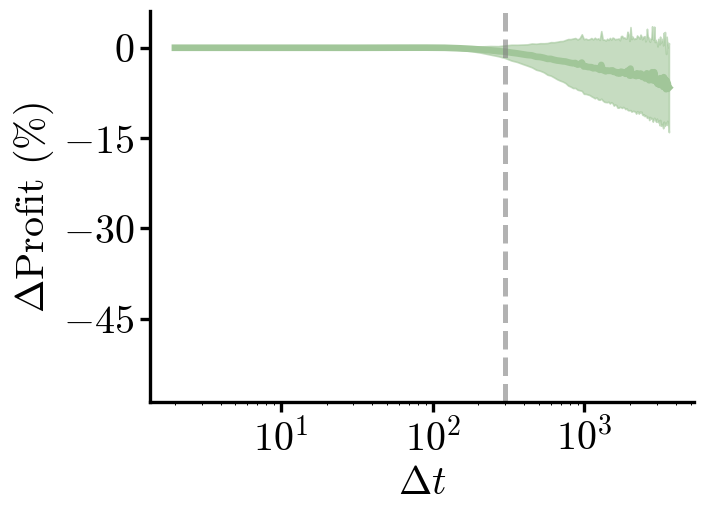

In [11]:
fig = plt.figure(dpi=120)

ax = fig.add_subplot()
ax.plot(control_frequencies[:], relative_change_mean.iloc[:], linewidth=4, color=colors[0])

ax.fill_between(control_frequencies[:], relative_change_mean.iloc[:] - relative_change_std.iloc[:], relative_change_mean.iloc[:] + relative_change_std.iloc[:], color=colors[0], alpha=0.6)

ax.set_ylabel(r"$\Delta$Profit (%)")
ax.set_xlabel(r"$\Delta t$") 

ax.set_xscale('log')
ylim = (-58.80595347004319, 6.0380082942254525)
# ylim = ax.get_ylim()#[ , ax.get_ylim()[1]]
ax.vlines(300, ylim[0], ylim[1], linestyle="--", linewidth=3, color='grey', alpha=0.6)
ax.set_ylim(ylim)

ax.yaxis.set_major_locator(MaxNLocator(nbins=6))
fig.tight_layout()
fig.savefig("delta_profit.svg")
plt.show()


In [19]:
relative_change_mean.head(50)

Control frequency
2.0       0.000000
4.0      -0.000662
8.0      -0.002225
16.0     -0.000901
30.0     -0.003678
60.0      0.010705
90.0      0.014388
120.0    -0.004848
150.0    -0.086647
180.0    -0.189528
210.0    -0.308205
240.0    -0.427145
270.0    -0.567853
300.0    -0.654455
330.0    -0.810091
360.0    -0.933575
390.0    -1.075008
420.0    -1.203378
450.0    -1.268996
480.0    -1.490261
510.0    -1.532391
540.0    -1.665645
570.0    -1.845539
600.0    -1.848820
630.0    -2.005795
660.0    -2.116227
690.0    -2.175926
720.0    -2.249716
750.0    -2.287098
780.0    -2.411691
810.0    -2.509378
840.0    -2.576314
870.0    -2.529840
900.0    -2.797397
930.0    -2.730233
960.0    -2.461544
990.0    -3.111457
1020.0   -3.072254
1050.0   -3.197155
1080.0   -3.209722
1110.0   -3.220207
1140.0   -3.411394
1170.0   -3.361318
1200.0   -3.407398
1230.0   -3.510681
1260.0   -3.667688
1290.0   -2.847856
1320.0   -3.714177
1350.0   -3.799377
1380.0   -3.912261
Name: Relative Change in Profit,

In [12]:
# steps_per_episode = df.groupby('Control frequency').nunique()


In [13]:
def relative_diff_twb(df, constraint_violation):
    '''
    Compute relative difference between time within boundary for a specific state variable.
    '''


    episode_length_per_control_freq = df[df['episode'] == 1].groupby('Control frequency')['episode'].sum()
    violation_df = df.assign(Violation = df[constraint_violation] >= 0)
    violation_df = violation_df.groupby(['Control frequency', 'episode'])['Violation'].sum().reset_index()
    violation_df['CF_Value'] = violation_df['Control frequency'].map(episode_length_per_control_freq)
    violation_df['TWB'] = violation_df['Violation'] / violation_df['CF_Value'] * 100

    reference_df = violation_df[violation_df['Control frequency'] == 2.0]['TWB']


    violation_df['Relative Change in TWB'] = violation_df.apply(
        lambda row: ((row['TWB'] - reference_df.loc[row['episode']]) / reference_df.loc[row['episode']]  *100) 
                    if row['Control frequency'] != 2.0 else 0, axis=1)



    violation_df_mean = violation_df.groupby('Control frequency', as_index=False)['Relative Change in TWB'].mean()
    violation_df_std = violation_df.groupby('Control frequency', as_index=False)['Relative Change in TWB'].std()

    return violation_df_mean, violation_df_std


In [14]:
df = step_size_run_time_data[1]
violations = ['CO2 violation','Temperature violation', 'Humidity violation']
twb_change = []
twb_change_std = []
for violation in violations:
    df_mean, df_std = relative_diff_twb(df, violation)
    twb_change.append(df_mean)
    twb_change_std.append(df_std)

In [23]:
for i in range(3): print(twb_change[i].head(40))

    Control frequency  Relative Change in TWB
0                 2.0                0.000000
1                 4.0               -0.000370
2                 8.0               -0.000875
3                16.0               -0.002430
4                30.0               -0.004551
5                60.0               -0.009507
6                90.0               -0.014482
7               120.0               -0.013055
8               150.0               -0.008132
9               180.0               -0.001463
10              210.0                0.025935
11              240.0                0.012516
12              270.0               -0.041819
13              300.0               -0.000944
14              330.0               -0.040693
15              360.0                0.040562
16              390.0               -0.079844
17              420.0               -0.141869
18              450.0               -0.041752
19              480.0               -0.265030
20              510.0             

(-58.80595347004319, 6.0380082942254525)


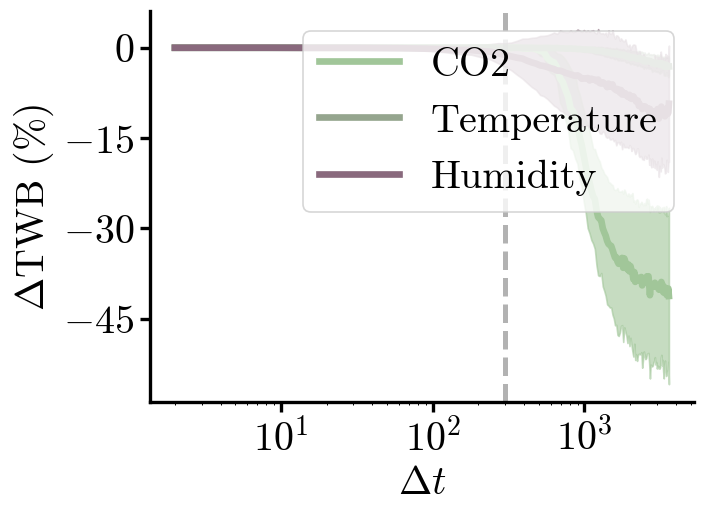

In [15]:
fig = plt.figure(dpi=120)

ax = fig.add_subplot()
labels= ['CO2','Temperature', 'Humidity']

for i, twb in enumerate(twb_change):
    ax.plot(control_frequencies[:], twb['Relative Change in TWB'].iloc[:], linewidth=4, color=colors[i], label=labels[i])

    ax.fill_between(control_frequencies[:], twb['Relative Change in TWB'].iloc[:] - twb_change_std[i]['Relative Change in TWB'].iloc[:], twb['Relative Change in TWB'].iloc[:] + twb_change_std[i]['Relative Change in TWB'].iloc[:], color=colors[i], alpha=0.6)

    # ax.fill_between(control_frequencies[:], twb['Relative Change in TWB'].iloc[1:] - Relative Change in TWB_change_std[i]['Relative Change in TWB'].iloc[1:], Relative Change in TWB['Relative Change in TWB'].iloc[1:] + Relative Change in TWB_change_std[i]['Relative Change in TWB'].iloc[1:], color=colors[i], alpha=0.6)

ylim = ax.get_ylim()
ax.vlines(300, ylim[0], ylim[1], linestyle="--", linewidth=3, color='grey', alpha=0.6)
ax.set_ylim(ylim)
print(ylim)
ax.set_ylabel(r"$\Delta$TWB (%)")
ax.set_xlabel(r"$\Delta t$") 

ax.set_xscale('log')
ylim = [-9 , ax.get_ylim()[1]]
ax.legend()
ax.yaxis.set_major_locator(MaxNLocator(nbins=6))
fig.tight_layout()
fig.savefig("delta_twb.svg")
plt.show()